# Convolutional Neural Networks

## Data

In [ ]:
import pandas as pd

target = 'country'
input_column = 'description_cleaned'

data = pd.read_excel('wine_reviews-top4.xlsx')


train_data = data[:45000]
dev_data = data[45000:60000]
test_data = data[60000:]

train_instances = train_data[input_column].apply(str).apply(str.split)
train_labels = train_data[target]

# collect known word tokens and tags
wordset, labelset = set(), set()

# collect tags from all data, to prevent unseen labels
labelset.update(set(data[target]))

for words in train_instances:
    wordset.update(set(words))

# map words and tags into ints
PAD = '-PAD-'
UNK = '-UNK-'
word2int = {word: i + 2 for i, word in enumerate(sorted(wordset))}
word2int[PAD] = 0  # special token for padding
word2int[UNK] = 1  # special token for unknown words
 
label2int = {label: i for i, label in enumerate(sorted(labelset))}
# to translate it back
int2label = {i:label for label, i in label2int.items()}


def convert2ints(instances):
    result = []
    for words in instances:
        # replace words with int, 1 for unknown words
        word_ints = [word2int.get(word, 1) for word in words]
        result.append(word_ints)
    return result
                          
train_instances_int = convert2ints(train_instances)
train_labels_int = [label2int[label] for label in train_labels]

In [ ]:
data

,country,description,designation,points,price,province,region_1,region_2,variety,winery,description_cleaned
0,US,This wine drinks qualitatively above and behin...,NaN,91,14.0,California,Sonoma Coast,Sonoma,Pinot Noir,Broken Clouds,wine drink qualitatively its low price deliver...
1,US,"Soft and creamy, with flavors of buttered toas...",NaN,87,20.0,California,Napa Valley,Napa,Chardonnay,Robert Mondavi,soft creamy flavor buttered toast pineapple ma...
2,US,"A bit too soft, which makes the exceptionally ...",Reserve,85,50.0,California,Sonoma County,Sonoma,Cabernet Sauvignon,Viansa,bit too soft which make exceptionally ripe bla...
3,US,"Dark purple, with mixed aromas of juicy plum, ...",NaN,83,28.0,Colorado,Grand Valley,NaN,Cabernet Sauvignon,Balistreri,dark purple mixed aroma juicy plum sawdust clo...
4,Italy,Le Coste Mosconi delivers a very attractive en...,Le Coste Mosconi,92,94.0,Piedmont,Barolo,NaN,Nebbiolo,Parusso,deliver very attractive ensemble ripe fruit ar...
...,...,...,...,...,...,...,...,...,...,...,...
75264,US,"Ripe in cherry and chocolate fruit, with a sli...",NaN,87,24.0,California,Sonoma County,Sonoma,Merlot,Selby,ripe cherry chocolate fruit slightly rustic mo...
75265,Italy,"Made using organically farmed fruit, this is a...",Ca' Fiui,86,24.0,Veneto,Valpolicella,NaN,"Corvina, Rondinella, Molinara",Corte Sant' Alda,make use organically farm fruit be simple frui...
75266,Italy,"Shows a pretty, polished nose with dusty miner...",Riserva,93,118.0,Tuscany,Brunello di Montalcino,NaN,Sangiovese Grosso,Lisini,show pretty polished nose dusty mineral note b...
75267,France,"This is not just a late harvest wine, because ...",Vendanges Tardives Gewurztraminer,90,NaN,Alsace,Alsace,NaN,Gewürztraminer,Rieflé,be not just late harvest wine there be definit...


In [ ]:
data.country.value_counts()

US        40528
Italy     14846
France    14452
Spain      5443
Name: country, dtype: int64

In [ ]:
len(word2int)

12115

## Exercise
Add a minimum frequency threshold for words, and replace any that are below with the `-UNK-` token.

In [ ]:
# your code here

## Convert Text data

In [ ]:
# convert test data 
test_instances = test_data[input_column].apply(str).apply(str.split)
test_labels = test_data[target]

test_instances_int = convert2ints(test_instances)
test_labels_int = [label2int[label] for label in test_labels]

# convert dev data
dev_instances = dev_data[input_column].apply(str).apply(str.split)
dev_labels = dev_data[target]

dev_instances_int = convert2ints(dev_instances)
dev_labels_int = [label2int[label] for label in dev_labels]

In [ ]:
from keras.utils import to_categorical

train_labels_1hot = to_categorical(train_labels_int, len(label2int))
test_labels_1hot = to_categorical(test_labels_int, len(label2int))
dev_labels_1hot = to_categorical(dev_labels_int, len(label2int))

train_labels_1hot[0]

array([0., 0., 0., 1.], dtype=float32)

In [ ]:
# compute 95th percentile of training sentence lengths
L = sorted(map(len, train_instances))
MAX_LENGTH = L[int(len(L)*0.95)]
print(MAX_LENGTH)

# apply padding
from keras.preprocessing.sequence import pad_sequences
train_instances_int = pad_sequences(train_instances_int, padding='post', maxlen=MAX_LENGTH)
test_instances_int = pad_sequences(test_instances_int, padding='post', maxlen=MAX_LENGTH)
dev_instances_int = pad_sequences(dev_instances_int, padding='post', maxlen=MAX_LENGTH)

print(train_instances[0], len(train_instances[0]))
print(train_instances_int[0], len(train_instances_int[0]))

39
['wine', 'drink', 'qualitatively', 'its', 'low', 'price', 'deliver', 'light', 'clear', 'color', 'tangy', 'wisps', 'cranberry', 'citrus', 'ting', 'minerality', 'depth', 'character', 'that', 'build', 'midpalate', 'finish', 'lean', 'crisp', 'wonderfully', 'elegant', 'expression', 'variety'] 28
[11900  3284  8306  5597  6123  8071  2917  5964  2019  2157 10570 11931
  2570  1971 10843  6543  2955  1787 10739  1445  6498  4066  5871  2621
 11954  3455  3816 11542     0     0     0     0     0     0     0     0
     0     0     0] 39


## CNN

In [ ]:
from keras.models import Model
from keras.layers import Input
from keras.layers import Embedding
from keras.layers.convolutional import Conv1D
from keras.layers import GlobalMaxPooling1D, Dropout
from keras.layers.core import Dense, Activation
import numpy as np

np.random.seed(42)

# set parameters of matrices and convolution
embedding_dim = 64
nb_filter = 64
filter_length = 3
hidden_dims = 32
stride_length = 1

inputs = Input((MAX_LENGTH, ), 
               name='word_IDs')
embeddings = Embedding(len(word2int), 
                       embedding_dim, 
                       input_length=MAX_LENGTH)(inputs)
convolution = Conv1D(filters=nb_filter,  # Number of filters to use
                    kernel_size=filter_length, # n-gram range of each filter.
                    padding='same',  #valid: don't go off edge; same: use padding before applying filter
                    activation='relu',
                    strides=stride_length)(embeddings)
convolution2 = Activation(activation='tanh')(convolution)
pooling = GlobalMaxPooling1D()(convolution2)
dropout1 = Dropout(0.2)(pooling)
dense = Dense(hidden_dims, activation='relu')(dropout1)
dropout2 = Dropout(0.2)(dense)
output = Dense(len(label2int), activation='softmax')(dropout2)

model = Model(inputs=[inputs], outputs=[output])
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
word_IDs (InputLayer)        [(None, 39)]              0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 39, 64)            775360    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 39, 64)            12352     
_________________________________________________________________
activation_2 (Activation)    (None, 39, 64)            0         
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 64)                0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080

In [ ]:
# batch size can have a huge effect on performance!
batch_size = 64
epochs = 5

history = model.fit(train_instances_int, train_labels_1hot,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(dev_instances_int, dev_labels_1hot)
                   )

loss, accuracy = model.evaluate(test_instances_int, test_labels_1hot,
                                batch_size=batch_size,
                                verbose=False)

print("\nTesting Accuracy:  {:.4f}".format(accuracy))

Epoch 1/5
704/704 [==============================] - 15s 20ms/step - loss: 0.8363 - accuracy: 0.6740 - val_loss: 0.2949 - val_accuracy: 0.9003
Epoch 2/5
704/704 [==============================] - 14s 21ms/step - loss: 0.2759 - accuracy: 0.9088 - val_loss: 0.2422 - val_accuracy: 0.9201
Epoch 3/5
704/704 [==============================] - 14s 20ms/step - loss: 0.1721 - accuracy: 0.9455 - val_loss: 0.2388 - val_accuracy: 0.9210
Epoch 4/5
704/704 [==============================] - 15s 21ms/step - loss: 0.1131 - accuracy: 0.9640 - val_loss: 0.2479 - val_accuracy: 0.9233
Epoch 5/5
704/704 [==============================] - 15s 21ms/step - loss: 0.0850 - accuracy: 0.9729 - val_loss: 0.2625 - val_accuracy: 0.9226

Testing Accuracy:  0.9203


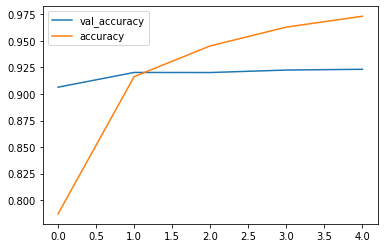

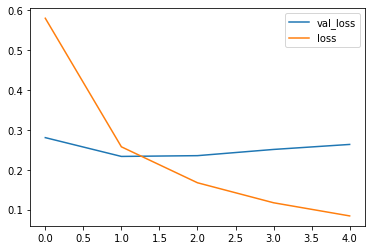

In [ ]:
%matplotlib inline
df = pd.DataFrame(history.history)
df[['val_accuracy', 'accuracy']].plot.line();
df[['val_loss', 'loss']].plot.line();

## Exercise
Implement a simple n-gram Logistic Regression model and evaluate its performance with `classification report`

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report

# your code here

## Exercise
Transform the CNN predictions into integer labels and run the classification report on it.

In [1]:
# your code here


# BERT


In [2]:
! pip install transformers

     |████████████████████████████████| 4.0 MB 5.7 MB/s 
     |████████████████████████████████| 880 kB 35.9 MB/s 
     |████████████████████████████████| 6.6 MB 35.4 MB/s 
     |████████████████████████████████| 596 kB 55.2 MB/s 
     |████████████████████████████████| 77 kB 5.3 MB/s 
     |████████████████████████████████| 96 kB 5.9 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.50-py3-none-any.whl size=895166 sha256=0581b873d0891db1dc5e53d5efac1317e06ea45f8dc16e35c407e023e137f05d
  Stored in directory: /root/.cache/pip/wheels/d9/72/54/519f0d5143cc6c73fa3297509123c86fc8586a7fdea8d25311
Successfully built sacremoses
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Attempting uninstall: click
    Found existing installation: click 7.1.2
    Uninstalling click-7.1.2:
      Successfully uninstalled click-7.1.2
ERROR: pip's dependency resolver does not currently take into a

In [3]:
from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModel.from_pretrained("bert-base-uncased")

inputs = tokenizer("Hello world!", return_tensors="pt")
outputs = model(**inputs)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [4]:
outputs.keys()

odict_keys(['last_hidden_state', 'pooler_output'])

Extract BERT representation

In [5]:
features = outputs['last_hidden_state'][:,0,:]
features.shape

torch.Size([1, 768])

In [6]:
features

tensor([[-1.4241e-01,  1.3354e-01, -1.2907e-01, -1.7165e-01, -4.8323e-01,
         -3.1157e-01,  6.0217e-01,  5.4625e-01, -2.1580e-01, -1.9043e-02,
         -7.4071e-02, -4.4620e-01, -1.0311e-02,  6.0428e-01,  1.6948e-01,
         -1.4628e-01, -1.2411e-01,  5.8711e-01,  1.7504e-01, -1.0010e-01,
         -1.8634e-01, -3.4341e-01, -3.2426e-01, -1.9991e-01,  2.1986e-01,
         -3.2447e-01,  6.0174e-03, -3.2935e-02,  3.4173e-01, -1.2281e-01,
         -1.3096e-01,  1.4538e-01, -1.6009e-01,  9.9210e-02, -1.1447e-01,
          6.4772e-02, -6.0367e-02,  2.0706e-01, -4.5022e-01, -1.8533e-01,
         -4.1603e-02, -3.7566e-01,  1.9985e-01,  5.2166e-03,  5.1030e-02,
         -4.2367e-01, -2.5318e+00, -2.6909e-02, -2.9580e-01, -4.2322e-01,
          3.9448e-01,  1.5304e-01,  5.8653e-02, -1.3344e-01, -2.5113e-02,
          2.6380e-01, -5.3140e-01,  5.8500e-01,  6.0789e-03,  1.5785e-02,
         -4.3840e-02, -4.4199e-02,  1.8870e-01, -3.4186e-02,  3.6056e-01,
         -4.2141e-02,  2.1860e-01,  8.

You can use ANY bert model for extracting the representation of a text! It is possible both to use multilingual models or models trained in other languages. You can check here for the complete list of models https://huggingface.co/models?filter=masked-lm

## Use fine-tuned BERT for text classification

You can also use pre-trained BERT models already fine-tuned for text classification! For example, this is the list of the models fine-tuned for Sentiment Analysis https://huggingface.co/models?filter=sentiment

In [7]:
import torch
import numpy as np 
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Load model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("MilaNLProc/feel-it-italian-sentiment")
model = AutoModelForSequenceClassification.from_pretrained("MilaNLProc/feel-it-italian-sentiment")

sentence = 'Oggi sono proprio contento!'
inputs = tokenizer(sentence, return_tensors="pt")

# Call the model and get the logits
labels = torch.tensor([1]).unsqueeze(0)  # Batch size 1
outputs = model(**inputs, labels=labels)
loss, logits = outputs[:2]
logits = logits.squeeze(0)

# Extract probabilities
proba = torch.nn.functional.softmax(logits, dim=0)

# Unpack the tensor to obtain negative and positive probabilities
negative, positive = proba
print(f"Probabilities: Negative {np.round(negative.item(),4)} - Positive {np.round(positive.item(),4)}")

Downloading:   0%|          | 0.00/414 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/847 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/775k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.60M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/299 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/422M [00:00<?, ?B/s]

Probabilities: Negative 0.0003 - Positive 0.9997
